# Deep Learning with PyTorch


Author: [Anand Saha](http://teleported.in/)

### 5. Autoencoder: denoising images

In [1]:
import torch
import torch.cuda as cuda
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

# Torchvision module contains various utilities, classes, models and datasets 
# used towards computer vision usecases
from torchvision import datasets
from torchvision import transforms

# Functional module contains helper functions
#import torch.nn.functional as F

**Create the datasets**

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

https://www.cs.toronto.edu/~kriz/cifar.html

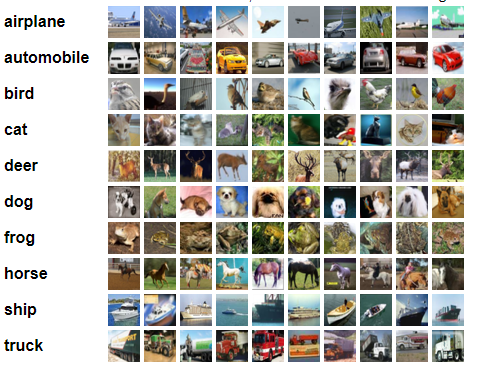

In [2]:
transform=transforms.Compose([transforms.ToTensor()])

cifar10_train = datasets.CIFAR10('./data.cifar10', train=True, download=True, transform=transform)
cifar10_valid = datasets.CIFAR10('./data.cifar10', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


**Utility to display the original, noisy and denoised image**

In [3]:
def show_img(orig, noisy, denoised):
    fig=plt.figure()
    
    orig = orig.swapaxes(0, 1).swapaxes(1, 2)
    noisy = noisy.swapaxes(0, 1).swapaxes(1, 2)
    denoised = denoised.swapaxes(0, 1).swapaxes(1, 2)
    
    # Normalize for display purpose
    orig     = (orig - orig.min()) / (orig.max() - orig.min())
    noisy    = (noisy - noisy.min()) / (noisy.max() - noisy.min())
    denoised = (denoised - denoised.min()) / (denoised.max() - denoised.min())
    
    fig.add_subplot(1, 3, 1, title='Original')
    plt.imshow(orig)
    
    fig.add_subplot(1, 3, 2, title='Noisy')
    plt.imshow(noisy)
    
    fig.add_subplot(1, 3, 3, title='Denoised')
    plt.imshow(denoised)
    
    fig.subplots_adjust(wspace = 0.5)
    plt.show()
    
# To test
# show_img(cifar10_train[0][0].numpy(), cifar10_train[1][0].numpy(), cifar10_train[2][0].numpy())

**Some hyper parameters**

In [4]:
batch_size = 500 # Reduce this if you get out-of-memory error
learning_rate = 0.001
noise_level = 0.1

**Create the dataloader**

In [5]:
cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=batch_size, shuffle=True, num_workers=1)
cifar10_valid_loader = torch.utils.data.DataLoader(cifar10_valid, batch_size=batch_size, shuffle=True, num_workers=1)

**The Denoising Autoencoder**

In [6]:
class DenoisingAutoencoder(nn.Module):
    
    def __init__(self):
    
        super(DenoisingAutoencoder, self).__init__()
                                                            # 32 x 32 x 3 (input)

        self.conv1e = nn.Conv2d(3, 24, 3, padding=2)        # 30 x 30 x 24
        self.conv2e = nn.Conv2d(24, 48, 3, padding=2)       # 28 x 28 x 48
        self.conv3e = nn.Conv2d(48, 96, 3, padding=2)       # 26 x 26 x 96
        self.conv4e = nn.Conv2d(96, 128, 3, padding=2)      # 24 x 24 x 128
        self.conv5e = nn.Conv2d(128, 256, 3, padding=2)     # 22 x 22 x 256
        self.mp1e   = nn.MaxPool2d(2, return_indices=True)  # 11 x 11 x 256

        self.mp1d = nn.MaxUnpool2d(2)
        self.conv5d = nn.ConvTranspose2d(256, 128, 3, padding=2)
        self.conv4d = nn.ConvTranspose2d(128, 96, 3, padding=2)
        self.conv3d = nn.ConvTranspose2d(96, 48, 3, padding=2)
        self.conv2d = nn.ConvTranspose2d(48, 24, 3, padding=2)
        self.conv1d = nn.ConvTranspose2d(24, 3, 3, padding=2)
        
    
    def forward(self, x):
        # Encoder
        x = self.conv1e(x)
        x = self.conv2e(x)
        x = self.conv3e(x)
        x = self.conv4e(x)
        x = self.conv5e(x)
        x, i = self.mp1e(x)
        
         # Decoder
        x = self.mp1d(x, i)
        x = self.conv5d(x)
        x = self.conv4d(x)
        x = self.conv3d(x)
        x = self.conv2d(x)
        x = self.conv1d(x)
        
        return x


In [7]:
autoencoder = DenoisingAutoencoder().cuda()
parameters = list(autoencoder.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

Iteration  1


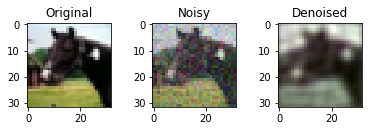

Iteration  2


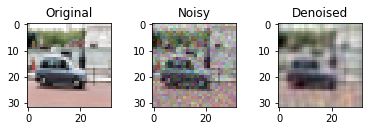

Iteration  3


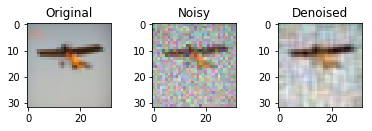

Iteration  4


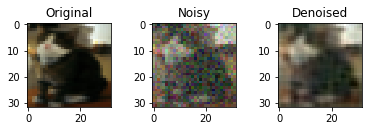

Iteration  5


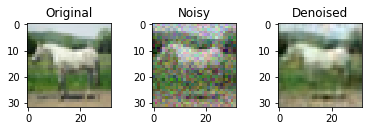

Iteration  6


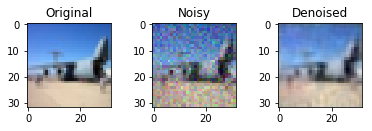

Iteration  7


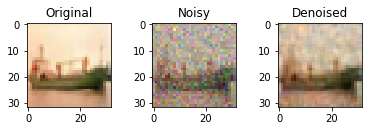

Iteration  8


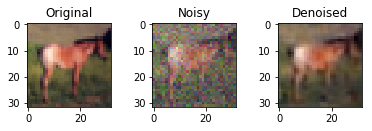

Iteration  9


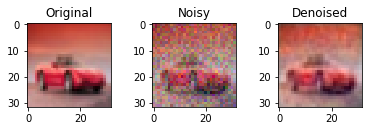

Iteration  10


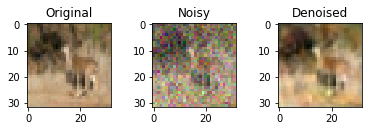

Iteration  11


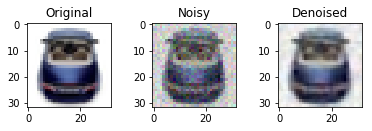

Iteration  12


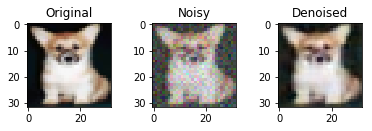

Iteration  13


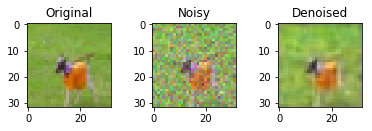

Iteration  14


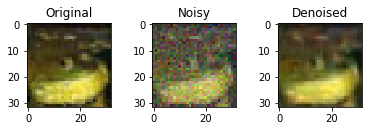

Iteration  15


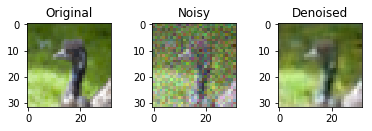

Iteration  16


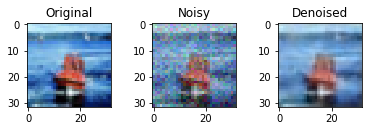

Iteration  17


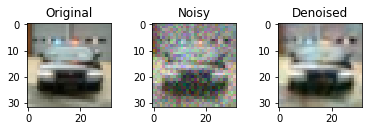

Iteration  18


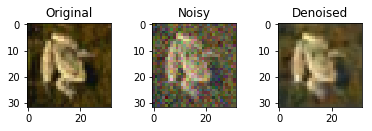

Iteration  19


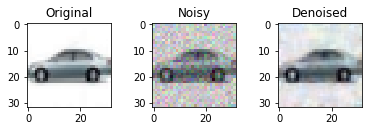

Iteration  20


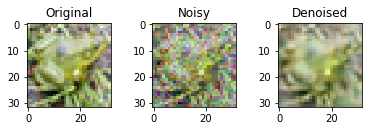

Iteration  21


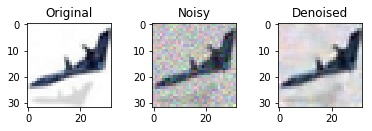

Iteration  22


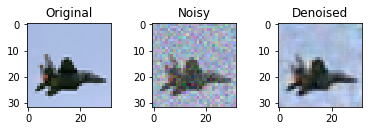

Iteration  23


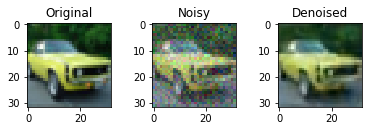

Iteration  24


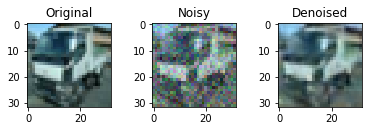

Iteration  25


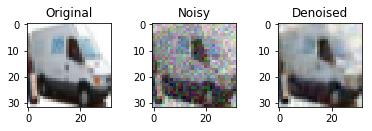

Iteration  26


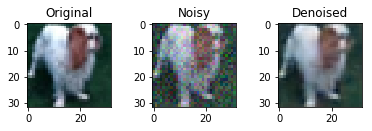

Iteration  27


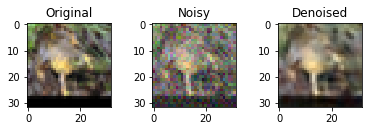

Iteration  28


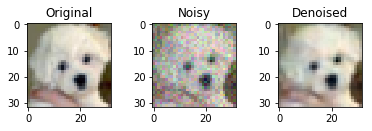

Iteration  29


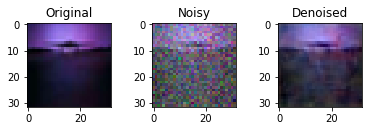

Iteration  30


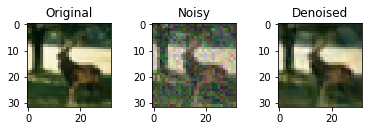

Iteration  31


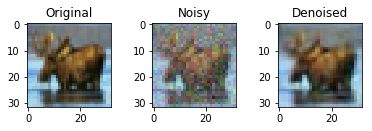

Iteration  32


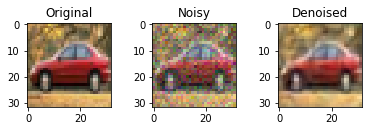

Iteration  33


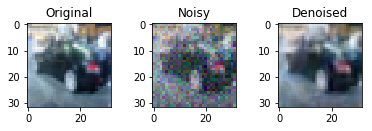

Iteration  34


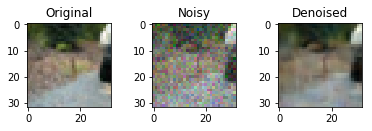

Iteration  35


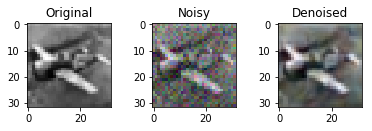

Iteration  36


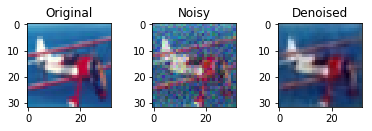

Iteration  37


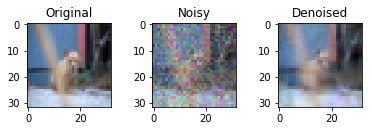

Iteration  38


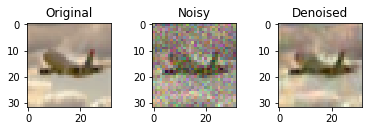

Iteration  39


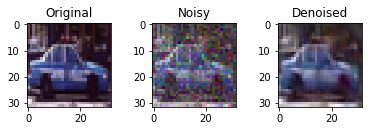

Iteration  40


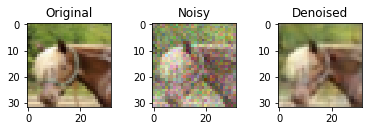

Iteration  41


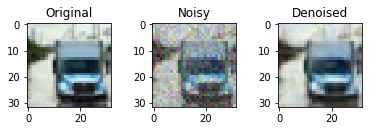

Iteration  42


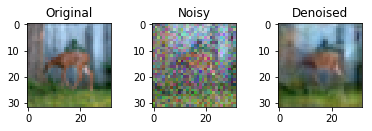

Iteration  43


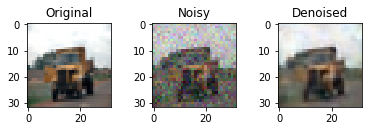

Iteration  44


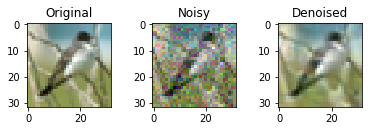

Iteration  45


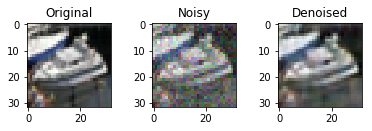

Iteration  46


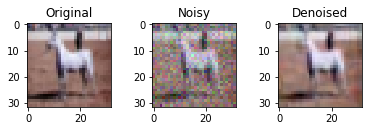

Iteration  47


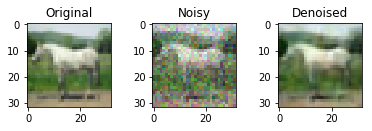

Iteration  48


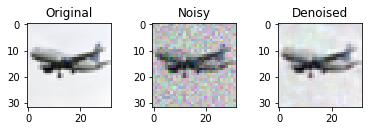

Iteration  49


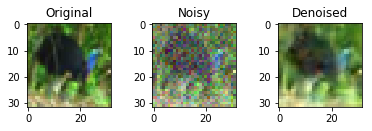

Iteration  50


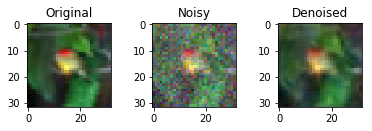

In [8]:
train_loss = []
valid_loss = []

for i in range(50):
    
    # Let's train the model
    
    total_loss = 0.0
    total_iter = 0
    autoencoder.train()
    for image, label in cifar10_train_loader:
        
        noise = torch.randn(batch_size, 3, 32, 32) * noise_level
        image_n = torch.add(image, noise)
        
        image = Variable(image).cuda()
        image_n = Variable(image_n).cuda()

        optimizer.zero_grad()
        output = autoencoder(image_n)
        
        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()
        
        total_iter += 1
        total_loss += loss.data[0]
        
    # Let's record the validation loss
    
    total_val_loss = 0.0
    total_val_iter = 0
    autoencoder.eval()
    for image, label in cifar10_valid_loader:
        
        noise = torch.randn(batch_size, 3, 32, 32) * noise_level
        image_n = torch.add(image, noise)
        
        image = Variable(image).cuda()
        image_n = Variable(image_n).cuda()
        
        output = autoencoder(image_n)
        loss = loss_func(output, image)
        
        total_val_iter += 1
        total_val_loss += loss.data[0]
        
        
    # Let's visualize the first image of the last batch in our validation set
    orig = image[0].cpu()
    noisy = image_n[0].cpu()
    denoised = output[0].cpu()

    orig = orig.data.numpy()
    noisy = noisy.data.numpy()
    denoised = denoised.data.numpy()

    print("Iteration ", i+1)
    show_img(orig, noisy, denoised)
    
    train_loss.append(total_loss / total_iter)
    valid_loss.append(total_val_loss / total_val_iter)
    
    # TODO Delete Me
    import time
    time.sleep(10)

In [9]:
# Save the model
torch.save(autoencoder.state_dict(), "./5.autoencoder.pth")